In [255]:
def load_images(container_path, description=None, categories=None,
               load_content=True, shuffle=True, target_size=None, gray=True, flatten=True, random_state=0):
    from sklearn.utils import Bunch, check_random_state
    import cv2
    from os import environ, listdir, makedirs
    from os.path import dirname, exists, expanduser, isdir, join, splitext
    import numpy as np
    """
    Parameters
    ----------
    container_path : string or unicode
        Path to the main folder holding one subfolder per category
    description : string or unicode, optional (default=None)
        A paragraph describing the characteristic of the dataset: its source,
        reference, etc.
    categories : A collection of strings or None, optional (default=None)
        If None (default), load all the categories. If not None, list of
        category names to load (other categories ignored).
    load_content : boolean, optional (default=True)
        Whether to load or not the content of the different files. If true a
        'data' attribute containing the text information is present in the data
        structure returned. If not, a filenames attribute gives the path to the
        files.
    shuffle : bool, optional (default=True)
        Whether or not to shuffle the data: might be important for models that
        make the assumption that the samples are independent and identically
        distributed (i.i.d.), such as stochastic gradient descent.
    encoding : string or None (default is None)
        If None, do not try to decode the content of the files (e.g. for images
        or other non-text content). If not None, encoding to use to decode text
        files to Unicode if load_content is True.
    decode_error : {'strict', 'ignore', 'replace'}, optional
        Instruction on what to do if a byte sequence is given to analyze that
        contains characters not of the given `encoding`. Passed as keyword
        argument 'errors' to bytes.decode.
    random_state : int, RandomState instance or None (default=0)
        Determines random number generation for dataset shuffling. Pass an int
        for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    Returns
    -------
    data : Bunch
        Dictionary-like object, the interesting attributes are: either
        data, the raw text data to learn, or 'filenames', the files
        holding it, 'target', the classification labels (integer index),
        'target_names', the meaning of the labels, and 'DESCR', the full
        description of the dataset.
    """
    target = []
    target_names = []
    filenames = []

    folders = [f for f in sorted(listdir(container_path))
               if isdir(join(container_path, f))]

    if categories is not None:
        folders = [f for f in folders if f in categories]

    for label, folder in enumerate(folders):
        target_names.append(folder)
        folder_path = join(container_path, folder)
        documents = [join(folder_path, d)
                     for d in sorted(listdir(folder_path))]
        target.extend(len(documents) * [label])
        filenames.extend(documents)

    # convert to array for fancy indexing
    filenames = np.array(filenames)
    target = np.array(target)

    if shuffle:
        random_state = check_random_state(random_state)
        indices = np.arange(filenames.shape[0])
        random_state.shuffle(indices)
        filenames = filenames[indices]
        target = target[indices]

    if load_content:
        data = []
        for filename in filenames:
            img = cv2.imread(filename)
            if target_size:
                img = cv2.resize(img, target_size)
            if gray:
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
            if flatten:
                img = img.flatten()
            data.append(img)
        data = np.array(data)
        return Bunch(data=data,
                     filenames=filenames,
                     target_names=target_names,
                     target=target,
                     DESCR=description)

    return Bunch(filenames=filenames,
                 target_names=target_names,
                 target=target,
                 DESCR=description)

In [256]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline                               

from glob import glob
from keras.backend.tensorflow_backend import set_session
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D, AveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, image
from keras.optimizers import SGD

In [257]:
TRAINING_DIR = 'data/data_new/'
TESTING_DIR = 'data/data_test'
IMAGE_SIZE = 64
RANDOM_STATE = 157
BATCH_SIZE = 20

PIECE_NAMES = [item[14:] for item in sorted(glob(TRAINING_DIR + "/*"))]
target_names = PIECE_NAMES

In [258]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
)

In [259]:
train_generator = data_generator.flow_from_directory(
    TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=RANDOM_STATE, 
    color_mode='grayscale', class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = data_generator.flow_from_directory(
    TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=RANDOM_STATE,
    color_mode='grayscale', class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 773 images belonging to 7 classes.
Found 256 images belonging to 7 classes.


In [276]:
### TODO: Define your architecture.
model = Sequential()
# model.add(ZeroPadding2D((1, 1), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))

# Layer 1
model.add(BatchNormalization(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 5
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 6
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(GlobalMaxPooling2D())
model.add(BatchNormalization())
model.add(Dense(512, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='elu'))
model.add(BatchNormalization())
model.add(Dense(7, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_218 (Bat (None, 64, 64, 1)         4         
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 64, 64, 64)        640       
_________________________________________________________________
batch_normalization_219 (Bat (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_220 (Bat (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 32, 32, 64)        36928     
__________

In [277]:
model.compile(loss='categorical_crossentropy', optimizer='adadelta')

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.piece_class.hdf5', 
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [262]:
epochs = 50
batch_size = 25

model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpointer, early_stopping],
)

Epoch 1/50
39/39 [==============================] - 16s 403ms/step - loss: 2.8269 - val_loss: 2.1096

Epoch 00001: val_loss improved from inf to 2.10956, saving model to saved_models/weights.best.piece_class.hdf5
Epoch 2/50
39/39 [==============================] - 4s 91ms/step - loss: 1.1655 - val_loss: 3.7719

Epoch 00002: val_loss did not improve from 2.10956
Epoch 3/50
39/39 [==============================] - 3s 86ms/step - loss: 0.7768 - val_loss: 1.4112

Epoch 00003: val_loss improved from 2.10956 to 1.41116, saving model to saved_models/weights.best.piece_class.hdf5
Epoch 4/50
39/39 [==============================] - 3s 86ms/step - loss: 0.4810 - val_loss: 0.4934

Epoch 00004: val_loss improved from 1.41116 to 0.49340, saving model to saved_models/weights.best.piece_class.hdf5
Epoch 5/50
39/39 [==============================] - 3s 86ms/step - loss: 0.5752 - val_loss: 1.1958

Epoch 00005: val_loss did not improve from 0.49340
Epoch 6/50
39/39 [==============================] - 3s 

In [279]:
model.load_weights('saved_models/weights.best.piece_class.hdf5')

In [280]:
_test = load_images(TESTING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), flatten=False)
X_test, y_test = _test.data, _test.target

In [281]:
X_pred = np.expand_dims(X_test, axis=3).astype('float32')/255
print(X_pred.shape)

(104, 64, 64, 1)


In [283]:
_y_pred = model.predict(X_pred)
y_pred = [np.argmax(i) for i in _y_pred]

In [284]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [285]:
accuracy_score(y_test, y_pred)

0.9807692307692307

In [286]:
f1_score(y_test, y_pred, average='micro')

0.9807692307692307

In [287]:
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(len(target_names))))

              precision    recall  f1-score   support

      BISHOP       1.00      1.00      1.00        16
       BLANK       1.00      1.00      1.00        16
        KING       1.00      1.00      1.00        12
      KNIGHT       1.00      1.00      1.00        16
        PAWN       1.00      1.00      1.00        16
       QUEEN       1.00      0.83      0.91        12
        ROOK       0.89      1.00      0.94        16

   micro avg       0.98      0.98      0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

[[16  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  0 16  0  0]
 [ 0  0  0  0  0 10  2]
 [ 0  0  0  0  0  0 16]]


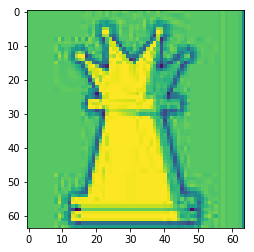

QUEEN ROOK


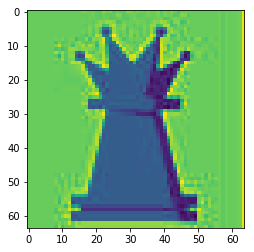

QUEEN ROOK


In [288]:
for i in range(len(y_test)):
    if y_test[i] != y_pred[i]:
        img = X_test[i]
        plt.imshow(X_test[i])
        plt.show()
        print(target_names[y_test[i]], target_names[y_pred[i]])